In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import pickle
from imp import reload
from os.path import join

import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

from data_loader import DataLoader
import medim
reload(medim);

In [2]:
raw_path = '/home/mount/neuro-t01-hdd/Brats2017/data/raw/'

data_loader = DataLoader(raw_path)
patients = data_loader.patients

In [3]:
%%time
mscans = [data_loader.load_mscan(data_loader.hgg_patients[i]) for i in range(5)]
segmentations = [data_loader.load_segmentation(data_loader.hgg_patients[i]) for i in range(5)]

CPU times: user 3.3 s, sys: 944 ms, total: 4.25 s
Wall time: 4.26 s


In [5]:
def show_hist_stats(scan, segmentation, show=True, bins=60, ax=None):
    #fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    for cancer_type in [0, 1, 2, 4]:
        mask = (segmentation == cancer_type)
        
        vals = scan[mask]
        if len(vals) == 0:
            continue
            
        drop_val = vals.min()
        vals = vals[vals != drop_val]
    
        top = np.percentile(vals, 99)
        vals = vals[vals < top]
        vals = np.clip(vals, drop_val, top)
    
        sns.distplot(vals, bins=bins, ax=ax)
    if show:
        plt.show() 

### Intensity distribution for different cancer tissues

100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


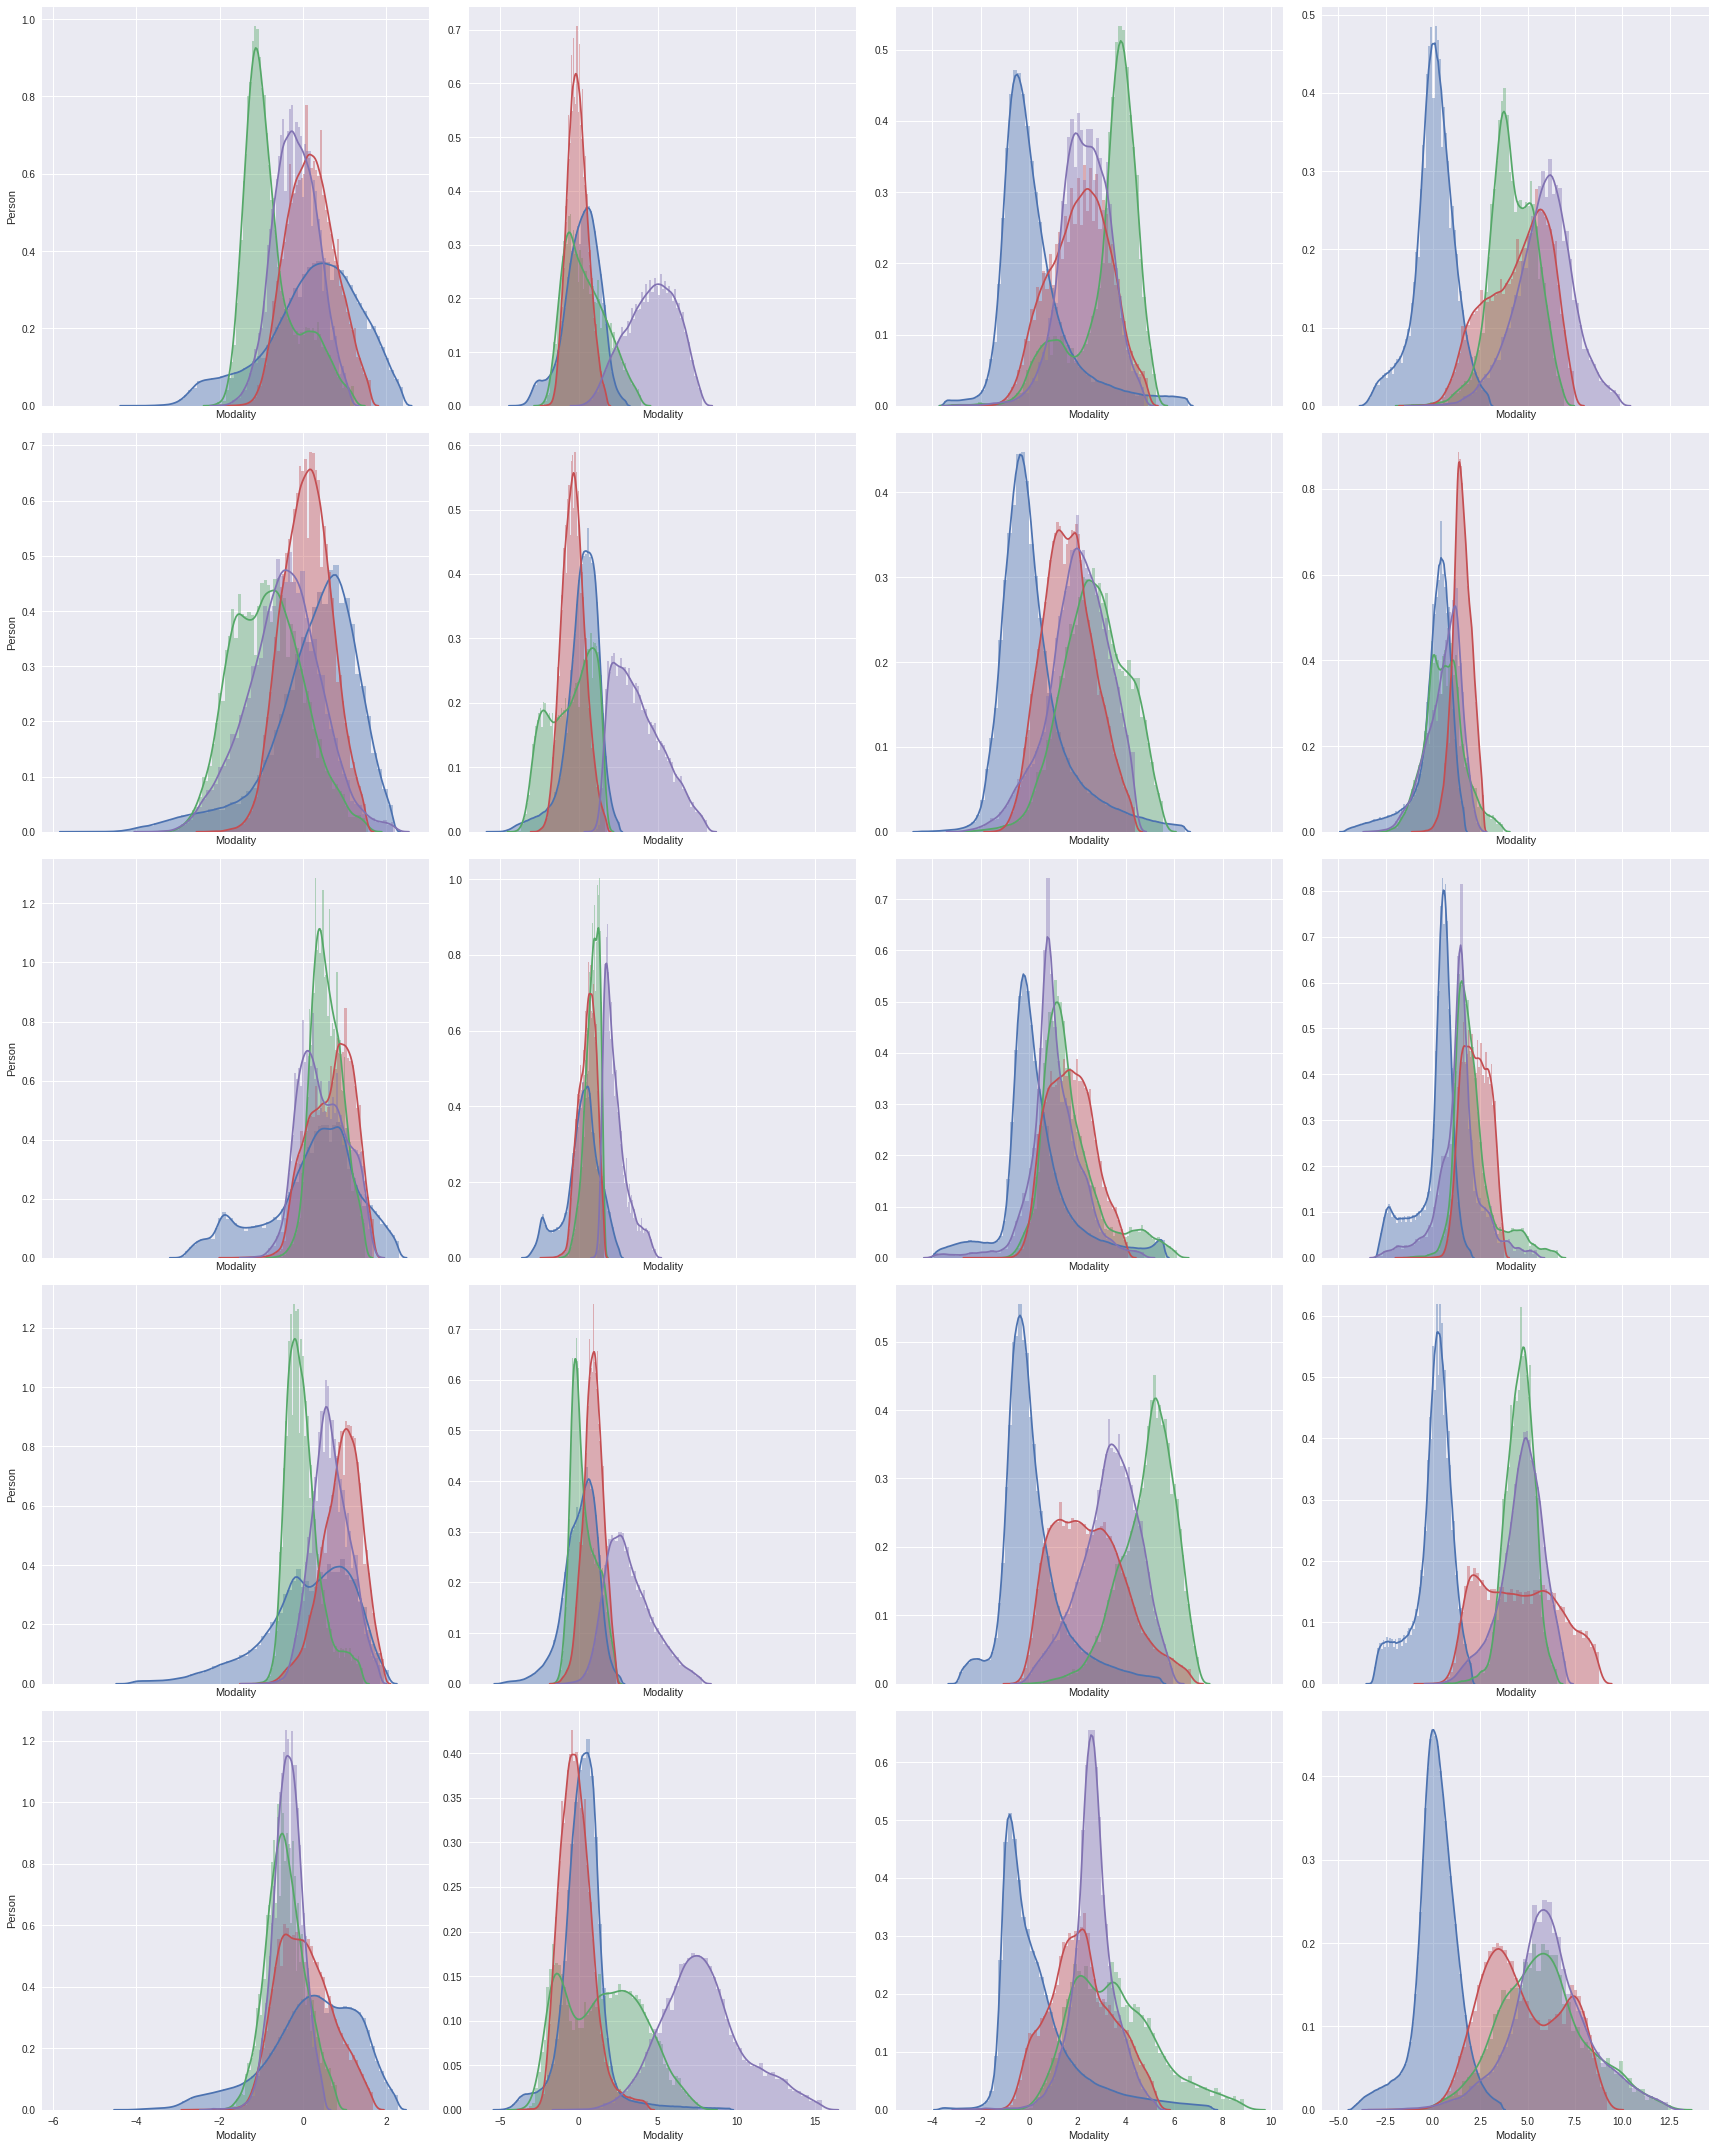

In [6]:
n_mscans = 5
n_modals = 4
fig, ax = plt.subplots(n_mscans, n_modals, figsize=(6*n_modals, 6*n_mscans),
                       sharex='col')

for i in tqdm(range(n_mscans)):
    ax[i, 0].set_ylabel('Person')
    for j in range(n_modals):
        ax[i, j].set_xlabel('Modality')
        show_hist_stats(medim.prep.normalize_scan(mscans[i][j]), segmentations[i], show=False, ax=ax[i, j])
plt.tight_layout()
plt.show()

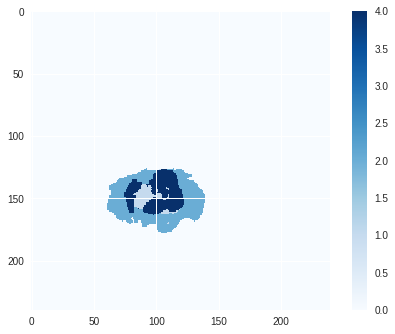

In [14]:
plt.imshow(segmentations[3][..., 80], cmap=cm.Blues)
plt.colorbar()

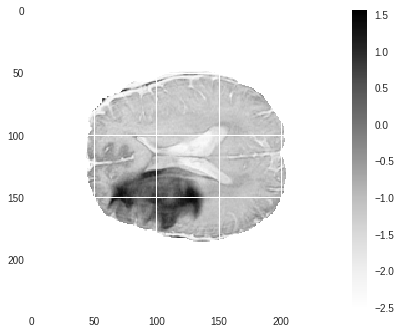

In [16]:
plt.imshow(medim.prep.normalize_scan(mscans[3])[3, ..., 80])
plt.colorbar()

In [9]:
stats = pd.read_csv('scan_stats.csv')

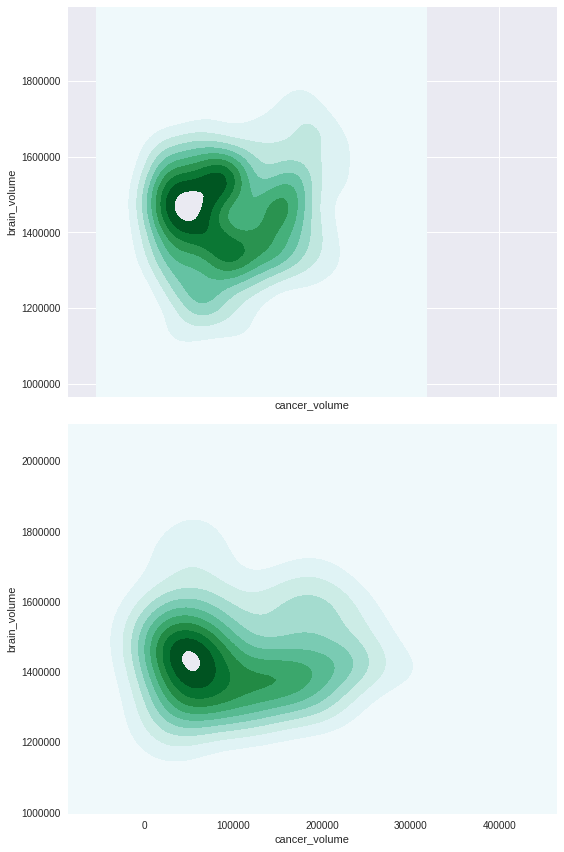

In [10]:
fig, ax = plt.subplots(2, figsize=(8, 12), sharex=True)

for i in range(2):
    subset = stats[stats.lgg_cancer == i]
    sns.kdeplot(subset['cancer_volume'], subset['brain_volume'], shade=True, ax=ax[i])

plt.tight_layout()
plt.show()

In [4]:
mask = np.any(mscans[0], axis=0)
a, b = medim.prep.bb.extract(mscans[0], segmentations[0], mask=mask)

In [8]:
a.shape, b.shape, np.any(mask, axis=(1, 2)).sum()

((4, 137, 161, 139), (137, 161, 139), 137)

In [32]:
m = sq_mscans[0]

In [44]:
m.dtype

dtype('float64')

In [42]:
m.nbytes // 1024 // 1024

106

In [43]:
4* m.size // 1024 // 1024

53

In [45]:
reload(medim.prep)

<module 'medim.preprocessing' from '/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/medim/preprocessing.py'>

In [18]:
def encode_segm(s):
    r = np.zeros((3, *s.shape), dtype=bool)
    r[0] = s > 0
    r[1] = (s == 1) | (s == 4)
    r[2] = (s == 4)
    return r

In [23]:
r = encode_segm(segmentations[3])

In [30]:
r.dtype

dtype('bool')

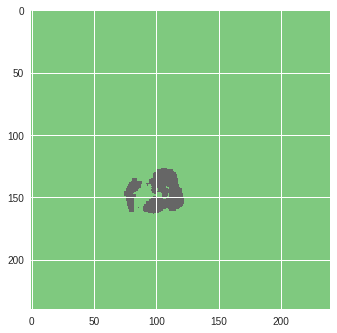

In [29]:
plt.imshow(r[2, ..., 80], cmap=cm.Accent)

In [32]:
processed_path = '/home/mount/neuro-t01-ssd/Brats2017/data/processed/'

for patient in tqdm(patients):
    mscan = data_loader.load_mscan(patient)
    segmentation = data_loader.load_segmentation(patient)
    
    mask = np.any(mscan, axis=0)
    sq_mscan, sq_segmentation = medim.bb.extract(mscan, segmentation, mask=mask)
    
    filename = join(processed_path, patient)
    np.save(filename+'_mscan', medim.prep.normalize_mscan(sq_mscan, drop_percentile=2))
    np.save(filename+'_segmentation', encode_segm(sq_segmentation))

100%|██████████| 285/285 [22:44<00:00,  7.44s/it]


In [55]:
processed_path = '/home/mount/neuro-t01-hdd/Brats2017/data/processed'
with open(join(processed_path, 'mscans.pkl'), 'wb') as f:
    pickle.dump(sq_mscans, f)
    
with open(join(processed_path, 'segmentation.pkl'), 'wb') as f:
    pickle.dump(sq_segmentations, f)

MemoryError: 